# Mtb variability

Download Mtb model iEK1366 from its [publication](https://doi.org/10.1186/s12918-018-0557-y).

In [1]:
import requests
import zipfile
import io

response = requests.get("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5834885/bin/12918_2018_557_MOESM3_ESM.zip", stream=True)
if response.status_code == 200:
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall("iEK1011")

In [2]:
import cobra
import pandas as pd

In [3]:
def calculate_flux_differences(solution_a: cobra.Solution, solution_b: cobra.Solution, tag_a="a", tag_b="b", threshold=1e-3) -> pd.DataFrame:
    fluxes = pd.merge(
        solution_a.to_frame()["fluxes"], solution_b.to_frame()["fluxes"],
        left_index=True, right_index=True,
        suffixes=(f"_{tag_a}", f"_{tag_b}")
    )
    fluxes["difference"] = fluxes[f"fluxes_{tag_b}"] - fluxes[f"fluxes_{tag_a}"]
    differences = fluxes[fluxes.difference.abs() > threshold].sort_values("difference", ascending=False, key=lambda x: x.abs())
    return differences

## Baseline growth in different environments

In [4]:
model_medium = cobra.io.load_json_model("iEK1011/iEK1011_m7H10_media.json")
model_invivo = cobra.io.load_json_model("iEK1011/iEK1011_inVivo_media.json")

In [5]:
print("Medium model:")
model_medium.summary()

Medium model:


Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac,0.3001,2,5.17%
cit_e,EX_cit,1,6,51.72%
fe3_e,EX_fe3,9.276E-05,0,0.00%
glu__L_e,EX_glu_L,1,5,43.10%
h_e,EX_h,4.846,0,0.00%
o2_e,EX_o2,2.633,0,0.00%
pi_e,EX_pi,0.02205,0,0.00%
so4_e,EX_so4,0.002206,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
4hba_e,EX_4hba,-1.325E-05,7,0.00%


In [6]:
print("In vivo model:")
model_invivo.summary()

In vivo model:


Metabolite,Reaction,Flux,C-Number,C-Flux
asn__L_e,EX_asn_L,1.503,4,14.96%
asp__L_e,EX_asp_L,5,4,49.76%
fe3_e,EX_fe3,0.0002207,0,0.00%
gln__L_e,EX_gln_L,0.08165,5,1.02%
glu__L_e,EX_glu_L,1,5,12.44%
h_e,EX_h,12.62,0,0.00%
no3_e,EX_no3,1.5,0,0.00%
nodcoa_e,EX_nodcoa,0.009931,40,0.99%
o2_e,EX_o2,0.5,0,0.00%
octscoa_e,EX_octscoa,0.1689,49,20.59%


In [7]:
medium_solution = model_medium.optimize()
invivo_solution = model_invivo.optimize()

results = calculate_flux_differences(medium_solution, invivo_solution, "medium", "invivo")
results.head(20)

,fluxes_medium,fluxes_invivo,difference
EX_h,-4.845535,-12.617863,-7.772328
EX_co2,0.000000,7.262449,7.262449
CO2t,0.000000,-7.262449,-7.262449
EX_nh4,0.886186,6.610290,5.724104
NH4t,-0.886186,-6.610290,-5.724104
CYTBD,5.263342,0.000000,-5.263342
ASPt2r,0.000000,5.000000,5.000000
EX_asp_L,0.000000,-5.000000,-5.000000
NADTRHD,4.205467,0.000000,-4.205467
BALAt2r,0.000000,-3.994074,-3.994074


## Isoniazide in different environments

Repeat what we did in the previous exercise.

In [8]:
medium_solution = model_medium.optimize()
with model_medium:
    model_medium.genes.Rv1484.knock_out()
    medium_solution_inhA = model_medium.optimize()
    reduction_percent = 100 * (medium_solution.objective_value - medium_solution_inhA.objective_value) / medium_solution.objective_value
    print(f"Medium growth with inhA KO ({medium_solution_inhA.status}) = {medium_solution_inhA.objective_value:g} ({reduction_percent:g} % reduction)")

Medium growth with inhA KO (optimal) = 0 (100 % reduction)


Compare it with the *in vivo* model.

In [9]:
invivo_solution = model_invivo.optimize()
with model_invivo:
    model_invivo.genes.Rv1484.knock_out()
    invivo_solution_inhA = model_invivo.optimize()
    reduction_percent = 100 * (invivo_solution.objective_value - invivo_solution_inhA.objective_value) / invivo_solution.objective_value
    print(f"In vivo growth with inhA KO ({invivo_solution_inhA.status}) = {invivo_solution_inhA.objective_value:g} ({reduction_percent:g} % reduction)")

In vivo growth with inhA KO (optimal) = 0 (100 % reduction)


## Isoniazide resistance in different environments

In [10]:
medium_solution = model_medium.optimize()
with model_medium:
    model_medium.genes.Rv1908c.knock_out()
    medium_solution_katG = model_medium.optimize()
    reduction_percent = 100 * (medium_solution.objective_value - medium_solution_katG.objective_value) / medium_solution.objective_value
    print(f"Medium growth with katG KO ({medium_solution_katG.status}) = {medium_solution_katG.objective_value:g} ({reduction_percent:g} % reduction)")

Medium growth with katG KO (optimal) = 0.016563 (0.0101493 % reduction)


In [11]:
invivo_solution = model_invivo.optimize()
with model_invivo:
    model_invivo.genes.Rv1908c.knock_out()
    invivo_solution_katG = model_invivo.optimize()
    reduction_percent = 100 * (invivo_solution.objective_value - invivo_solution_katG.objective_value) / invivo_solution.objective_value
    print(f"In vivo growth with katG KO ({invivo_solution_katG.status}) = {invivo_solution_katG.objective_value:g} ({reduction_percent:g} % reduction)")

In vivo growth with katG KO (optimal) = 0.0394142 (0 % reduction)


Difference between baseline and katG loss-of-function.

In [12]:
medium_differences_katG = calculate_flux_differences(medium_solution, medium_solution_katG, "baseline", "katG")
medium_differences_katG

,fluxes_baseline,fluxes_katG,difference


In [13]:
invivo_differences_katG = calculate_flux_differences(model_invivo.optimize(), invivo_solution_katG, "baseline", "katG")
invivo_differences_katG

,fluxes_baseline,fluxes_katG,difference


## Flux variability analysis (FVA), briefly

Here we perform FVA of the reactions that are altered upon a katG loss of function *in vitro* (`medium` model).

We set `loopless=True` because it makes more sense, thermodinamilally. [More info here](https://cobrapy.readthedocs.io/en/latest/loopless.html).

In [14]:
from cobra.flux_analysis import flux_variability_analysis as fva

fva_results = fva(model_medium, reaction_list=list(medium_differences_katG.index), loopless=True, fraction_of_optimum=0.85)
fva_results["optimum"] = model_medium.optimize()[medium_differences_katG.index]

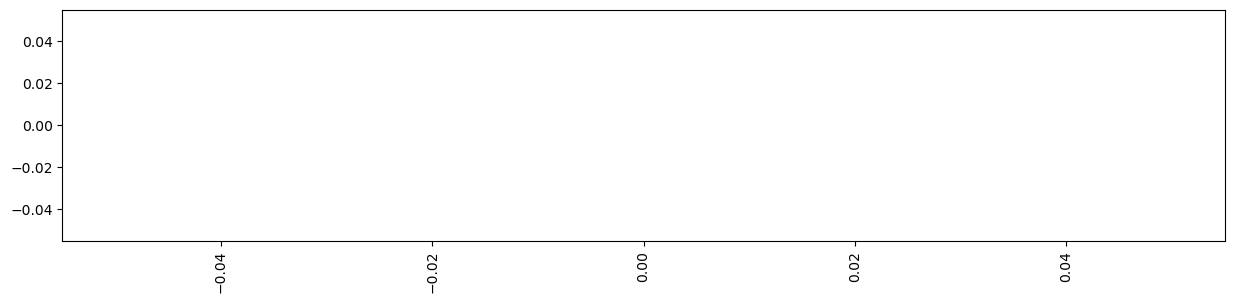

In [15]:
import matplotlib.pyplot as plt

x = fva_results.index
y = fva_results.optimum
ymin = (fva_results.optimum - fva_results.minimum).abs()
ymax = (fva_results.optimum - fva_results.maximum).abs()

fig, ax = plt.subplots(figsize=(15, 3))
ax.errorbar(x, y, yerr=(ymin, ymax), fmt ="o")
plt.xticks(rotation=90)
plt.show()

## Further analyses

Differences in gene essentiality depending on environment:

In [16]:
medium_essential = cobra.flux_analysis.find_essential_genes(model_medium)
invivo_essential = cobra.flux_analysis.find_essential_genes(model_invivo)

In [17]:
different_genes = set(gene.id for gene in medium_essential).symmetric_difference(set(gene.id for gene in invivo_essential))
for gene in different_genes:
    print(gene)

Rv1449c
Rv1310
Rv2201
Rv0733
Rv0337c
Rv3565
Rv2225
Rv3628
Rv2573
Rv1305
Rv0951
Rv1307
Rv1391
Rv1385
Rv0382c
Rv2495c
Rv1311
Rv2965c
Rv1308
Rv1306
Rv2496c
Rv2497c
Rv3602c
Rv2139
Rv1380
Rv1309
Rv1381
Rv0952
Rv1092c
Rv3140
Rv1304
Rv3601c
Rv1631


Gene list analyses with https://pantherdb.org:

- ORA (using lists of genes)
- GSEA (using fluxes through essential reactions)